In [1]:
import pickle

In [2]:
with open("../database/database.pickle", "rb") as db:
    database = pickle.load(db)

In [12]:
c = 0
for i in database.items():
    c+=1
    if i[1][0][1] != 6:
        print(i)
        break

print(c)

391287


In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from scipy import fft, signal
import scipy
from scipy.io.wavfile import read

In [8]:
class FingerprintPipeline:
    def __init__(self) -> None:
        self.root_path = "assets/torec"
        self.database_file = "database/database.pickle"
        self.song_index_file = "database/song_index.pickle"
        self.database = None
        self.song_name_index = None

    def create_constellation(self, audio, Fs):
        window_length_seconds = 0.5
        window_length_samples = int(window_length_seconds * Fs)
        window_length_samples += window_length_samples % 2 # for odd samples, add 1
        num_peaks = 15

        amount_to_pad = (  # Pad the song to divide evenly into windows
            window_length_samples - audio.size % window_length_samples
        )
        song_input = np.pad(audio, (0, amount_to_pad))

        frequencies, times, stft = signal.stft(
            song_input,
            Fs,
            nperseg=window_length_samples,
            nfft=window_length_samples,
            return_onesided=True,
        )

        constellation_map = []

        for time_idx, window in enumerate(stft.T):
            spectrum = abs(window)
            peaks, props = signal.find_peaks(spectrum, prominence=0, distance=200)

            n_peaks = min(num_peaks, len(peaks))
            largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
            for peak in peaks[largest_peaks]:
                frequency = frequencies[peak]
                constellation_map.append([time_idx, frequency])

        return constellation_map

    def create_hashes(self, constellation_map, song_id=None):
        hashes = {}
        # Use this for binning - 23_000 is slighlty higher than the maximum
        # frequency that can be stored in the .wav files, 22.05 kHz
        upper_frequency = 23_000
        frequency_bits = 10

        # Iterate the constellation
        for idx, (time, freq) in enumerate(constellation_map):
            # Iterate the next 100 pairs to produce the combinatorial hashes
            # When we produced the constellation before, it was sorted by time already
            # So this finds the next n points in time (though they might occur at the same time)
            for other_time, other_freq in constellation_map[idx : idx + 100]:
                diff = other_time - time
                # If the time difference between the pairs is too small or large
                # ignore this set of pairs
                if diff <= 1 or diff > 10:
                    continue

                # Place the frequencies (in Hz) into a 1024 bins
                freq_binned = freq / upper_frequency * (2**frequency_bits)
                other_freq_binned = other_freq / upper_frequency * (2**frequency_bits)

                # Produce a 32 bit hash
                # Use bit shifting to move the bits to the correct location
                hash = (
                    int(freq_binned)
                    | (int(other_freq_binned) << 10)
                    | (int(diff) << 20)
                )
                hashes[hash] = (time, song_id)
        return hashes

    def load_database(self):
        self.database = pickle.load(open(self.database_file, "rb"))
        self.song_name_index = pickle.load(open(self.song_index_file, "rb"))

    def recognize(self, file_name: str):
        self.load_database()
        Fs, audio_input = read(f"{self.root_path}/{file_name}")

        constellation = self.create_constellation(audio_input, Fs)
        hashes = self.create_hashes(constellation, None)

        matches_per_song = {}
        for hash, (sample_time, _) in hashes.items():
            if hash in self.database:
                matching_occurences = self.database[hash]
                for source_time, song_id in matching_occurences:
                    if song_id not in matches_per_song:
                        matches_per_song[song_id] = 0
                    matches_per_song[song_id] += 1

        song_names = []
        for song_id, num_matches in list(
            sorted(matches_per_song.items(), key=lambda x: x[1], reverse=True)
        )[:4]:
            song_names.append(self.song_name_index[song_id])

        return song_names

In [9]:
fl = FingerprintPipeline()

In [10]:
Fs, audio_input = read("assets/audio/Fix You - Coldplay.wav")

In [11]:
fl.create_constellation(audio_input, Fs)

[[0, 5800.0],
 [0, 10362.0],
 [0, 12460.0],
 [0, 11022.0],
 [0, 15682.0],
 [0, 708.0],
 [0, 9292.0],
 [0, 8394.0],
 [0, 3980.0],
 [0, 3390.0],
 [0, 2982.0],
 [0, 2486.0],
 [0, 1896.0],
 [0, 1280.0],
 [0, 128.0],
 [1, 8894.0],
 [1, 6878.0],
 [1, 7466.0],
 [1, 6308.0],
 [1, 5816.0],
 [1, 5396.0],
 [1, 4426.0],
 [1, 4936.0],
 [1, 3894.0],
 [1, 3416.0],
 [1, 2674.0],
 [1, 1900.0],
 [1, 1314.0],
 [1, 590.0],
 [1, 54.0],
 [2, 7084.0],
 [2, 7640.0],
 [2, 6640.0],
 [2, 4980.0],
 [2, 5396.0],
 [2, 4558.0],
 [2, 5950.0],
 [2, 3806.0],
 [2, 3228.0],
 [2, 2656.0],
 [2, 1622.0],
 [2, 2026.0],
 [2, 1218.0],
 [2, 588.0],
 [2, 122.0],
 [3, 8078.0],
 [3, 6550.0],
 [3, 5518.0],
 [3, 6092.0],
 [3, 584.0],
 [3, 4802.0],
 [3, 4350.0],
 [3, 3924.0],
 [3, 3450.0],
 [3, 2888.0],
 [3, 2446.0],
 [3, 2028.0],
 [3, 1470.0],
 [3, 1020.0],
 [3, 110.0],
 [4, 8276.0],
 [4, 7246.0],
 [4, 6688.0],
 [4, 7730.0],
 [4, 6092.0],
 [4, 5330.0],
 [4, 4558.0],
 [4, 2854.0],
 [4, 3926.0],
 [4, 3262.0],
 [4, 1682.0],
 [4, 2444.0

In [12]:
window_length_seconds = 0.5
window_length_samples = int(window_length_seconds * Fs)
print(window_length_samples)
window_length_samples += window_length_samples % 2

print(window_length_samples)

22050
22050


In [13]:
amount_to_pad = (  # Pad the song to divide evenly into windows
    window_length_samples - audio_input.size % window_length_samples
)

In [14]:
audio_input.size % window_length_samples

18442

In [15]:
__a =[3,4,5,7,3,6,2,6,8]

np.pad(__a, [0, 2])

array([3, 4, 5, 7, 3, 6, 2, 6, 8, 0, 0])

In [16]:
frequencies, times, stft = signal.stft(
    audio_input,
    Fs,
    nperseg=window_length_samples,
    nfft=window_length_samples,
    return_onesided=True,
)

In [17]:
stft.shape

(11026, 1177)

In [18]:
constellation_map = []
for idx, window in enumerate(stft.T):
    spectrum = abs(window)
    peaks, props = signal.find_peaks(spectrum, prominence=0, distance=200)

    print(peaks)
    print(props)

    num_peaks = 15
    n_peaks = min(num_peaks, len(peaks))
    largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]

    print(n_peaks)
    print(f"largest_peaks: {largest_peaks}")

    for peak in peaks[largest_peaks]:
        frequency = frequencies[peak]
        print(f"\nfrequencies: \n\n{frequencies}")
        constellation_map.append([idx, frequency])
        # print([idx, frequencies])

[   64   354   640   948  1243  1491  1695  1990  2237  2462  2699  2900
  3276  3624  3978  4197  4430  4646  4862  5181  5511  5820  6027  6230
  6459  6720  6992  7239  7497  7841  8078  8306  8530  8898  9219  9432
  9679 10072 10381 10629 10858]
{'prominences': array([0.32043564, 0.06047324, 0.03900146, 0.02593731, 0.01238523,
       0.00726498, 0.00804276, 0.0065785 , 0.00313305, 0.00590565,
       0.00174716, 0.00596772, 0.00456865, 0.00480414, 0.00457044,
       0.00669165, 0.00357106, 0.00701558, 0.00533581, 0.00604554,
       0.00646162, 0.00536612, 0.00092262, 0.00631064, 0.00504622,
       0.00592073, 0.00449795, 0.00551117, 0.00512332, 0.00687046,
       0.00301433, 0.00286816, 0.00195935, 0.00274256, 0.00229075,
       0.00272003, 0.00179439, 0.00213896, 0.00171949, 0.00221639,
       0.00173586]), 'left_bases': array([   35,   272,   452,   886,  1231,  1480,  1539,  1870,  2182,
        2182,  2657,  2182,  3040,  3518,  3518,  2182,  4427,  2182,
        4802,  4748,  

In [19]:
import matplotlib.pyplot as plt

In [20]:
constellation_map

[[0, 5800.0],
 [0, 10362.0],
 [0, 12460.0],
 [0, 11022.0],
 [0, 15682.0],
 [0, 708.0],
 [0, 9292.0],
 [0, 8394.0],
 [0, 3980.0],
 [0, 3390.0],
 [0, 2982.0],
 [0, 2486.0],
 [0, 1896.0],
 [0, 1280.0],
 [0, 128.0],
 [1, 8894.0],
 [1, 6878.0],
 [1, 7466.0],
 [1, 6308.0],
 [1, 5816.0],
 [1, 5396.0],
 [1, 4426.0],
 [1, 4936.0],
 [1, 3894.0],
 [1, 3416.0],
 [1, 2674.0],
 [1, 1900.0],
 [1, 1314.0],
 [1, 590.0],
 [1, 54.0],
 [2, 7084.0],
 [2, 7640.0],
 [2, 6640.0],
 [2, 4980.0],
 [2, 5396.0],
 [2, 4558.0],
 [2, 5950.0],
 [2, 3806.0],
 [2, 3228.0],
 [2, 2656.0],
 [2, 1622.0],
 [2, 2026.0],
 [2, 1218.0],
 [2, 588.0],
 [2, 122.0],
 [3, 8078.0],
 [3, 6550.0],
 [3, 5518.0],
 [3, 6092.0],
 [3, 584.0],
 [3, 4802.0],
 [3, 4350.0],
 [3, 3924.0],
 [3, 3450.0],
 [3, 2888.0],
 [3, 2446.0],
 [3, 2028.0],
 [3, 1470.0],
 [3, 1020.0],
 [3, 110.0],
 [4, 8276.0],
 [4, 7246.0],
 [4, 6688.0],
 [4, 7730.0],
 [4, 6092.0],
 [4, 5330.0],
 [4, 4558.0],
 [4, 2854.0],
 [4, 3926.0],
 [4, 3262.0],
 [4, 1682.0],
 [4, 2444.0

In [21]:
import math
def getY(x, b=0):
    return Sin((x + 2 ** x )/  x)


x = np.linspace(1, 10, 100)


y = getY(x, np.random.random([5, 20]))

plt.scatter(x, y, c="red")

NameError: name 'Sin' is not defined

In [ ]:
def Sin(x):
    sins = []
    for val in x:
        sins.append(math.sin(val))

    return sins

In [ ]:
from scipy.io.wavfile import read

In [ ]:
sr, audio_data = read('assets/audio/Fix You - Coldplay.wav')

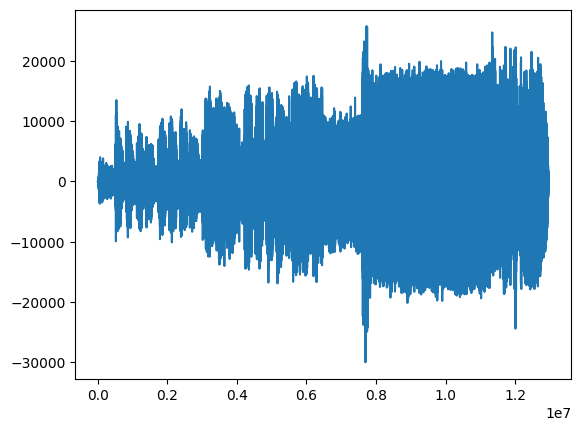

In [ ]:
plt.plot(audio_data)

In [ ]:
audio_freqs, audio_times, audio_stft = signal.stft(audio_data, sr, nperseg=sr/2, nfft=sr/2)

In [ ]:
audio_stft.shape

(11026, 1177)

/tmp/ipykernel_6102/1839798291.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=44100) >= signal length (=11026).
  plt.specgram(audio_stft[:], sr)


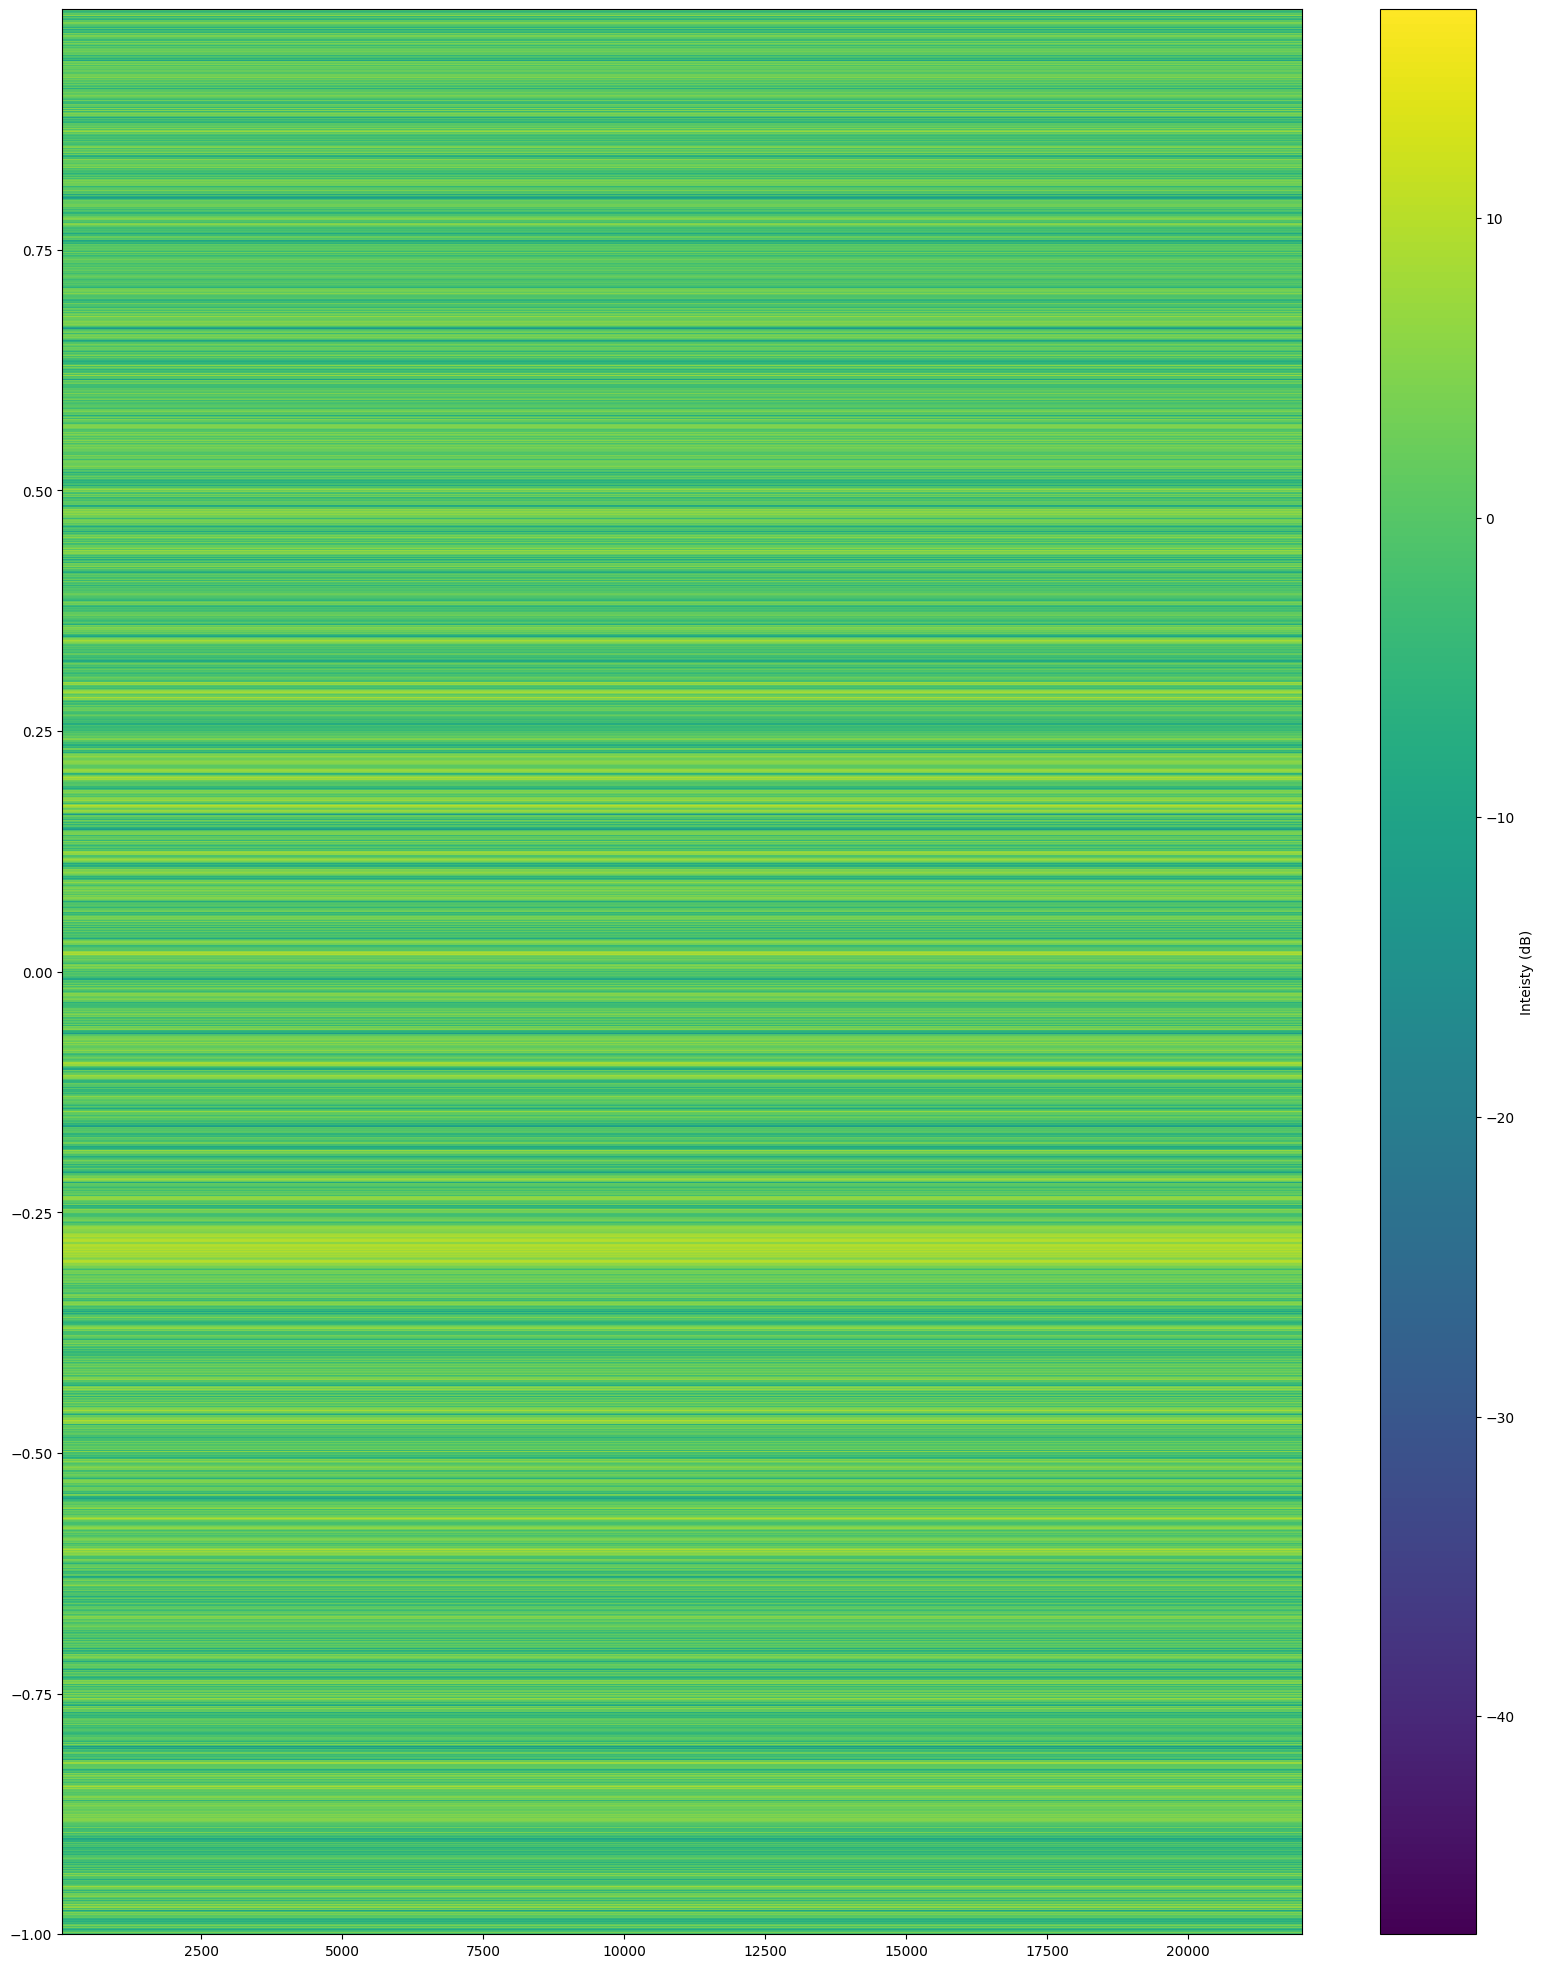

In [ ]:
plt.specgram(audio_stft[:], sr)
plt.colorbar(label='Inteisty (dB)')

plt.rcParams['figure.figsize'] = (10, 15)

In [76]:
def audio_print(fname, range_1=None, range_limit=None):
    fs, audio_data = read(f"{fname}")
    print(len(audio_data))
    if range_1 != None and range_limit != None:
        audio_data = audio_data[range_1:(range_limit + range_1)]
    audio_data = signal.stft(audio_data)[2]
    plt.specgram(audio_data, fs)

    return audio_data

474112


/tmp/ipykernel_5718/821795673.py:7: UserWarning: Only one segment is calculated since parameter NFFT (=44100) >= signal length (=129).
  plt.specgram(audio_data, fs)


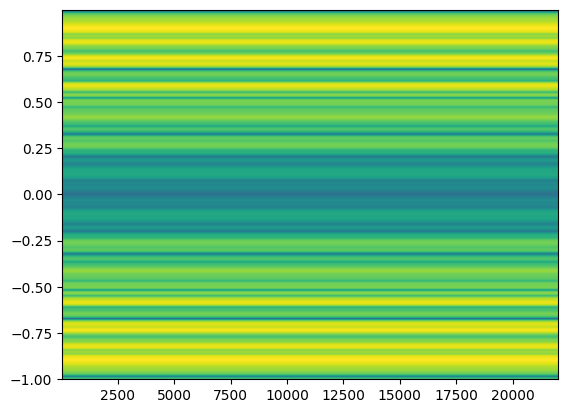

In [77]:
recorded_signal = audio_print("assets/torec/vw8P0MCDlkN0b3WoGnTmsg==.m4a.wav")

12961792


/tmp/ipykernel_5718/821795673.py:7: UserWarning: Only one segment is calculated since parameter NFFT (=44100) >= signal length (=129).
  plt.specgram(audio_data, fs)


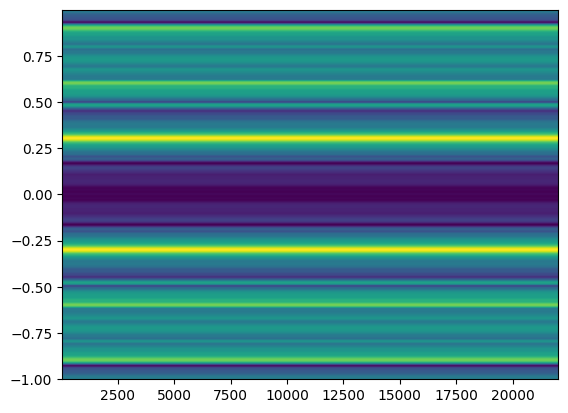

In [78]:
original_window = audio_print(
    "assets/audio/Fix You - Coldplay.wav", range_1=5865300, range_limit=387072
)

In [79]:
# plt.plot(recorded_signal - original_window)

ValueError: operands could not be broadcast together with shapes (129,3705) (129,3025) 

/home/imran/.local/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/tmp/ipykernel_5718/3982193101.py:3: UserWarning: Only one segment is calculated since parameter NFFT (=44100) >= signal length (=129).
  plt.specgram(weigner_signal, 44100)


(array([[2.50987370e-12],
        [2.48300742e-12],
        [2.45670559e-12],
        ...,
        [2.59385955e-12],
        [2.56529973e-12],
        [2.53730446e-12]]),
 array([-1.        , -0.99995465, -0.9999093 , ...,  0.99986395,
         0.9999093 ,  0.99995465]),
 array([11025.]),
 <matplotlib.image.AxesImage at 0x7fdcfec26550>)

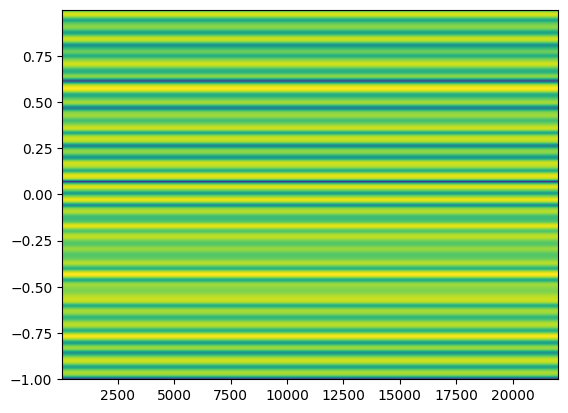

In [80]:
weigner_signal = signal.wiener(im=signal.stft(recorded_signal)[2])

plt.specgram(weigner_signal, 44100)

(129, 256, 30)

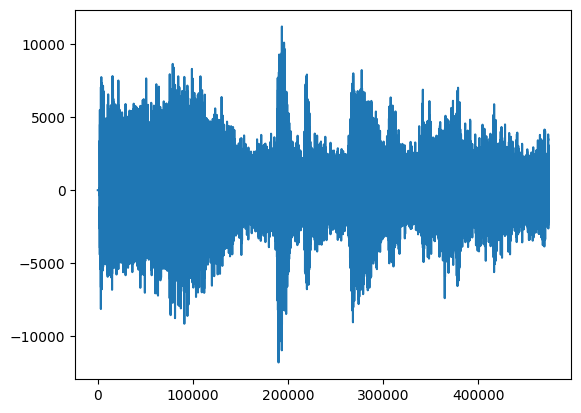

In [88]:
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wavfile


def remove_buzz(audio_file, buzz_frequency, output_file):
    # Load the audio file
    sample_rate, data = wavfile.read(audio_file)

    print("Original data")
    plt.plot(data)

    # Normalize the audio data
    normalized_data = data / (2.0**15)

    # Calculate the notch filter parameters
    center_frequency = buzz_frequency  # Frequency of the buzz signal
    width = 100.0  # Width of the notch filter

    # Design the notch filter
    nyquist = 0.5 * sample_rate
    notch_freq = center_frequency / nyquist
    b, a = signal.iirnotch(notch_freq, width)

    # Apply the notch filter to the audio data
    filtered_data = signal.lfilter(b, a, normalized_data)

    # Convert the filtered data back to integer values
    filtered_data_int = np.int16(filtered_data * (2.0**15))

    print("Filtered data")
    plt.plot(filtered_data_int)

    # Save the filtered audio to a new file
    wavfile.write(output_file, sample_rate, filtered_data_int)

    return filtered_data_int

Original data
Filtered data


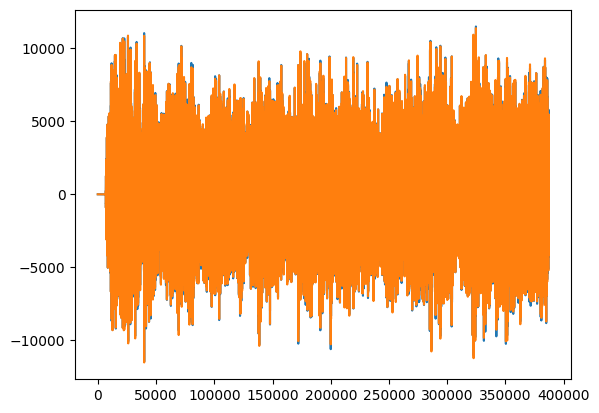

In [94]:
# Example usage:
audio_file_path = "assets/torec/8j41S8Q59scv4UIwbF-xzg==.m4a.wav"
output_file_path = "assets/filtered/audio.wav"
buzz_frequency_to_remove = (
    1000.0  # Replace this with the frequency of the buzz in your audio
)

filtered_data = remove_buzz(audio_file_path, buzz_frequency_to_remove, output_file_path)

In [95]:
fs, aud_data = read("assets/torec/8j41S8Q59scv4UIwbF-xzg==.m4a.wav")

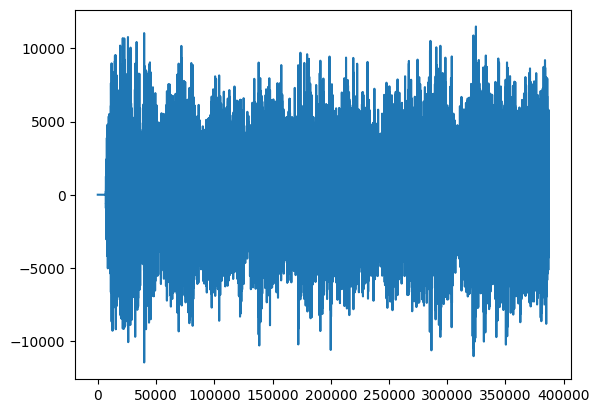

In [96]:
plt.plot(aud_data)

In [98]:
# `pip3 install assemblyai` (macOS)
# `pip install assemblyai` (Windows)

import assemblyai as aai

aai.settings.api_key = "bf2021855aed4795a4eb74c1ead7bd7c"
transcriber = aai.Transcriber()

transcript = transcriber.transcribe(
    "https://storage.googleapis.com/aai-web-samples/news.mp4"
)
# transcript = transcriber.transcribe("./my-local-audio-file.wav")

print(transcript.text)

I'm David Curley at the Smithsonian Aaron Space Museum, where we are marking 50 years since man landed and walked on the moon in a lander just like this one. We are going to show you some of the actual ABC News coverage from 50 years ago during that eight day mission of this remarkable achievement. Apollo Eleven's lander, the Eagle, would be the first manned craft to land on the moon. For training, NASA came with an unusual contraption. Neil Armstrong actually had to eject from it once, and then he had a couple of successful flights. ABC News Anchor at the time, 50 years ago, frank Reynolds with a look at that unusual trainer. Apollo Eleven commander Neil Armstrong is at the controls of a lunar landing training vehicle. Testing the reaction control jets, these thrusters stabilize the Lem during landing and takeoff. The LLTV is designed to simulate the behavior of the Lem as it lands in the moon's gravity. Lunar gravity is one 6th that of the Earth's. Neil Armstrong flew one of these ve

In [103]:
!pip install 'transformers[tf-cpu]'

  Obtaining dependency information for tensorflow-cpu<2.15,>=2.6 from https://files.pythonhosted.org/packages/cb/24/d8924df0c4dab455ab08365246fb773fbff24fb0a071f552239732b01b1f/tensorflow_cpu-2.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for onnxconverter-common from https://files.pythonhosted.org/packages/6d/6a/9ed9fd4da34cb41fda35bc5cc9e990c605689db7de63ed84fedbca5a77f6/onnxconverter_common-1.14.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tf2onnx from https://files.pythonhosted.org/packages/87/92/bfd60c946ad2925078e767acdbcf8bcee0b50f4e0df5aaf63d169ebcab59/tf2onnx-1.15.1-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-text<2.15 from https://files.pythonhosted.org/packages/aa/76/2af69939d95bdf36fe5339d4c2bd7a5909d3e666c561cf1cf3d874b423c6/tensorflow_text-2.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for k

In [1]:
from transformers import pipeline

/home/imran/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-27 16:43:37.285849: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 16:43:37.353720: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 16:43:37.503428: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 16:43:37.503476: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to reg

In [11]:
converter = pipeline('automatic-speech-recognition', "openai-whisper-large-v3")

OSError: openai-whisper-large-v3 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [1]:
import requests

In [2]:
host = "https://api.musixmatch.com/ws/1.1/"
apikey = "36cbfc51e9f49c11b1ceee8044017e27"

In [3]:
q_track = "lover"
q_artist = "taylor swift"

In [14]:
url = host + f"matcher.lyrics.get?apikey={apikey}&q_track={q_track}&q_artist={q_artist}"

In [15]:
response = requests.get(url)

In [20]:
import json

In [24]:
js_res_body = json.loads(response.text)

In [26]:
js_res_body['message']['body']['lyrics']['lyrics_body']

"We could leave the Christmas lights up 'til January\nAnd this is our place, we make the rules\nAnd there's a dazzling haze, a mysterious way about you dear\nHave I known you 20 seconds or 20 years?\n\nCan I go where you go?\nCan we always be this close forever and ever?\nAnd ah, take me out, and take me home\nYou're my, my, my, my\nLover\n\nWe could let our friends crash in the living room\nThis is our place, we make the call\n...\n\n******* This Lyrics is NOT for Commercial use *******"

In [5]:
converter

In [8]:
converter("assets/torec/speech_trial2.mp3")

{'text': 'DRUSS WORRERS BY BEREDE MDICSTAT YOU ISION'}

In [ ]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
# from datasets import load_dataset


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)

# dataset = load_dataset("distil-whisper/librispeech_long", "clean", split="validation")
# sample = dataset[0]["audio"]

# result = pipe(sample)
# print(result["text"])


model.safetensors:  79%|██████████████████████████████████████████████████████████████▎                | 2.43G/3.09G [03:42<00:53, 12.3MB/s]

In [16]:
!pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
